In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from PIL import Image

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [13]:
# Define paths for training and testing datasets
# These paths should be updated according to your directory structure
# The paths below are examples and should be replaced with actual paths on your system
train_img_path = "/home/lovish/PROJECTS/RealnessProject/Images/train_images"
train_csv_path = "/home/lovish/PROJECTS/RealnessProject/IRWD2/TrainGPT4_1.csv"


test_img_path = "/home/lovish/PROJECTS/RealnessProject/Images/test_images"
test_csv_path = "/home/lovish/PROJECTS/RealnessProject/IRWD2/TestGPT4_1.csv"

In [14]:
train_df=pd.read_csv(train_csv_path)
train_df
test_df=pd.read_csv(test_csv_path)
print(test_df.head)
#splitting the train_df into train and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)   

<bound method NDFrame.head of     filename       MOS                                        description
0   f244.png  0.681995  Somewhat. The front wheel appears distorted an...
1   f126.png  0.709697  No, there is nothing unrealistic in this image...
2     r3.png  1.223393  No, there is nothing unrealistic in this image...
3   f145.png -1.211034  Somewhat. The crowd in the background looks bl...
4   f170.png -0.696548  Yes. The giraffe's neck is unusually long and ...
..       ...       ...                                                ...
85   r25.png  0.299579  No, there is nothing unrealistic in this image...
86  f377.png -1.546216  Somewhat. While the gathering looks realistic ...
87  f291.png -1.839048  Yes. The player in white has an oddly position...
88  f438.png  0.628122  No, there is nothing unrealistic in this image...
89  f104.png -0.721600  No, there is nothing unrealistic in this image...

[90 rows x 3 columns]>


In [15]:
class RealismDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, tokenizer, transform):
        self.df = df
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"{self.image_dir}/{row['filename']}"
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        text = row['description']
        inputs = self.tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=128)

        mos = torch.tensor(row['MOS'], dtype=torch.float)
        return image, inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0), mos


In [16]:
class MOSPredictor(nn.Module):
    def __init__(self,hidden_dim):
        super(MOSPredictor, self).__init__()
        # ResNet-50
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # remove classification head
        self.hidden_dim=hidden_dim


        # BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
   

        # Fusion + Regression
        self.fc = nn.Sequential(
            nn.Linear(2048 + 768, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.cnn(image)  # shape: (batch_size, 2048)
        text_feat = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output  # (batch_size, 768)
        combined = torch.cat((img_feat, text_feat), dim=1)
        output = self.fc(combined)
        return output.squeeze(1)


In [17]:
transform = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Data augmentation
    #transforms.RandomGrayscale(p=0.1),  # Data augmentation
])
transform_test = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# dataset and dataloader
train_dataset = RealismDataset(train_df, image_dir=train_img_path, tokenizer=tokenizer, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

#validation dataset and dataloader
val_dataset = RealismDataset(val_df, image_dir=train_img_path, tokenizer=tokenizer, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# test dataset and dataloader
test_dataset = RealismDataset(test_df, image_dir=test_img_path, tokenizer=tokenizer, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [18]:
print("Train MOS Min:", train_df["MOS"].min(), "Max:", train_df["MOS"].max())
print("Val MOS Min:", val_df["MOS"].min(), "Max:", val_df["MOS"].max())
print("Test MOS Min:", test_df["MOS"].min(), "Max:", test_df["MOS"].max())


Train MOS Min: -3.090923105200146 Max: 1.3899444706055917
Val MOS Min: -2.8379724847409142 Max: 1.4919967114892982
Test MOS Min: -2.2998476664190064 Max: 1.2233925360606557


In [19]:
from scipy.stats import spearmanr,pearsonr
@torch.no_grad()
def evaluate_spearman(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    for images, input_ids, attention_mask, mos in test_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        mos = mos.to(device)

        preds = model(images, input_ids, attention_mask)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(mos.cpu().numpy())

    corr, _ = spearmanr(all_targets, all_preds)
    pearsonr_corr, _ = pearsonr(all_targets, all_preds)
    return corr, pearsonr_corr

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
device

device(type='cuda')

In [23]:
#load saved model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MOSPredictor(531).to(device)
model.load_state_dict(torch.load("/home/lovish/PROJECTS/RealnessProject/MODEL v2/Best_model_spearmanS.pth"))
model.eval()


#find the spearman correlation on the test set
spearman_corr, pearson_corr = evaluate_spearman(model, test_loader, device)
print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

/home/lovish/.virtualenvs/PythonProject1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lovish/.virtualenvs/PythonProject1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Spearman Correlation: 0.7773
Pearson Correlation: 0.8140


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

@torch.no_grad()
def get_text_embedding(text):
    """Return normalized text embedding."""
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True, truncation=True)
    text_features = clip_model.get_text_features(**inputs)
    return F.normalize(text_features, p=2, dim=-1)

@torch.no_grad()
def get_patch_embeddings(patches):
    """Return normalized embeddings for a batch of image patches."""
    inputs = clip_processor(images=patches, return_tensors="pt", padding=True)
    image_features = clip_model.get_image_features(**inputs)
    return F.normalize(image_features, p=2, dim=-1)

def generate_heat_map(image, text, window_size=64, stride=32, batch_size=64):
    """Generate a heatmap of similarity scores between image patches and a text prompt."""
    img_w, img_h = image.size
    heatmap = np.zeros((img_h, img_w), dtype=np.float32)
    count_map = np.zeros((img_h, img_w), dtype=np.float32)

    text_embedding = get_text_embedding(text)

    # Prepare all patches and their coordinates
    patch_coords = []
    patches = []

    for top in range(0, img_h - window_size + 1, stride):
        for left in range(0, img_w - window_size + 1, stride):
            patch = image.crop((left, top, left + window_size, top + window_size))
            patches.append(patch)
            patch_coords.append((top, left))

            # Process in batches
            if len(patches) == batch_size:
                embed_and_update(patches, patch_coords, text_embedding, heatmap, count_map, window_size)
                patches, patch_coords = [], []

    # Remaining patches
    if patches:
        embed_and_update(patches, patch_coords, text_embedding, heatmap, count_map, window_size)

    # Normalize heatmap
    np.divide(heatmap, count_map, out=heatmap, where=count_map != 0)
    return heatmap

def embed_and_update(patches, coords, text_emb, heatmap, count_map, window_size):
    """Helper function to embed patches and update heatmap."""
    patch_embeds = get_patch_embeddings(patches)
    sims = (patch_embeds @ text_emb.T).squeeze(-1).cpu().numpy()

    for (top, left), score in zip(coords, sims):
        heatmap[top:top+window_size, left:left+window_size] += score
        count_map[top:top+window_size, left:left+window_size] += 1
        #max logic
        

def to_pil_image(np_img):
    """Convert NumPy image (RGB/uint8 or float) to PIL."""
    if np_img.dtype != np.uint8:
        np_img = (np.clip(np_img, 0, 1) * 255).astype(np.uint8)
    if np_img.shape[-1] == 4:
        np_img = np_img[..., :3]
    return Image.fromarray(np_img)

# --- Main Execution ---

# Load and prepare image
np_img = plt.imread("/home/lovish/PROJECTS/RealnessProject/Images/test_images/f252.png") #MOS=1.0413785592771698
test_img = to_pil_image(np_img)

# Text description
test_text = ("Yes, there are some unrealistic elements. The transition between some arms and bodies is unnatural, and one athlete’s arm appears oddly merged with another, lacking realistic definition.")

flag_no=False
#if test_text starts with "No." or "no." or "no," set flag to True
if test_text.lower().startswith("no"):   
    flag_no = True


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [25]:
# Generate heatmap for test image 1 using Lovish's method
import os
start_times = os.times()
start_system_time = start_times.system
print("Generating heatmap1...")
heatmap1_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=4, batch_size=1024)
print("Generating heatmap2...")
heatmap2_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=8, batch_size=1024)
print("Generating heatmap3...")
heatmap3_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=16, batch_size=1024)

heatmap_avg1 = (heatmap1_img1 + heatmap2_img1 + heatmap3_img1) / 3

# Record system time after execution
end_times = os.times()
end_system_time = end_times.system

# Calculate system time used
system_time_used = end_system_time - start_system_time
user_time = os.times()
print(f"System time spent: {system_time_used:.4f} seconds")
print("User time:", user_time.user)

Generating heatmap1...


KeyboardInterrupt: 

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
from transformers import BlipProcessor, BlipForImageTextRetrieval
from PIL import Image

# Load BLIP ITM model and processor
blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco").eval()
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")

@torch.no_grad()
def get_text_embedding(text):
    """Return text features using BLIP ITM."""
    inputs = blip_processor(text=[text], return_tensors="pt", padding=True, truncation=True)
    text_outputs = blip_model.text_encoder(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )
    # CLS token embedding
    text_features = text_outputs.last_hidden_state[:, 0, :]  
    return F.normalize(text_features, p=2, dim=-1)

@torch.no_grad()
def get_patch_embeddings(patches):
    """Return image features for a batch of patches using BLIP ITM."""
    inputs = blip_processor(images=patches, return_tensors="pt")
    vision_outputs = blip_model.vision_model(**inputs)
    # CLS token embedding
    image_features = vision_outputs.last_hidden_state[:, 0, :]  
    return F.normalize(image_features, p=2, dim=-1)

def generate_heat_map(image, text, window_size=64, stride=32, batch_size=64):
    """Generate a heatmap of similarity scores between image patches and a text prompt."""
    img_w, img_h = image.size
    heatmap = np.zeros((img_h, img_w), dtype=np.float32)
    count_map = np.zeros((img_h, img_w), dtype=np.float32)

    text_embedding = get_text_embedding(text)

    # Prepare all patches and their coordinates
    patch_coords = []
    patches = []

    for top in range(0, img_h - window_size + 1, stride):
        for left in range(0, img_w - window_size + 1, stride):
            patch = image.crop((left, top, left + window_size, top + window_size))
            patches.append(patch)
            patch_coords.append((top, left))

            # Process in batches
            if len(patches) == batch_size:
                embed_and_update(patches, patch_coords, text_embedding, heatmap, count_map, window_size)
                patches, patch_coords = [], []

    # Remaining patches
    if patches:
        embed_and_update(patches, patch_coords, text_embedding, heatmap, count_map, window_size)

    # Normalize heatmap
    np.divide(heatmap, count_map, out=heatmap, where=count_map != 0)
    return heatmap

def embed_and_update(patches, coords, text_emb, heatmap, count_map, window_size):
    """Helper function to embed patches and update heatmap."""
    patch_embeds = get_patch_embeddings(patches)
    sims = (patch_embeds @ text_emb.T).squeeze(-1).cpu().numpy()

    for (top, left), score in zip(coords, sims):
        heatmap[top:top+window_size, left:left+window_size] += score
        count_map[top:top+window_size, left:left+window_size] += 1
        #max logic
        

def to_pil_image(np_img):
    """Convert NumPy image (RGB/uint8 or float) to PIL."""
    if np_img.dtype != np.uint8:
        np_img = (np.clip(np_img, 0, 1) * 255).astype(np.uint8)
    if np_img.shape[-1] == 4:
        np_img = np_img[..., :3]
    return Image.fromarray(np_img)

# --- Main Execution ---

# Load and prepare image
np_img = plt.imread("/home/lovish/PROJECTS/RealnessProject/Images/test_images/f252.png") #MOS=1.0413785592771698
test_img = to_pil_image(np_img)

# Text description
test_text = ("Yes, there are some unrealistic elements. The transition between some arms and bodies is unnatural, and one athlete’s arm appears oddly merged with another, lacking realistic definition.")

flag_no=False
#if test_text starts with "No." or "no." or "no," set flag to True
if test_text.lower().startswith("no"):   
    flag_no = True

In [10]:
import numpy as np
def to_pil_image(np_img):
    """Convert NumPy image (RGB/uint8 or float) to PIL."""
    if np_img.dtype != np.uint8:
        np_img = (np.clip(np_img, 0, 1) * 255).astype(np.uint8)
    if np_img.shape[-1] == 4:
        np_img = np_img[..., :3]
    return Image.fromarray(np_img)

In [11]:
np_img1 = plt.imread("/home/lovish/PROJECTS/RealnessProject/Images/test_images/f252.png") #MOS=1.0413785592771698
test_img1 = to_pil_image(np_img1)
test_text1 = ("Yes, there are some unrealistic elements. The transition between some arms and bodies is unnatural, and one athlete’s arm appears oddly merged with another, lacking realistic definition.")

np_img2 = plt.imread("/home/lovish/PROJECTS/RealnessProject/Images/test_images/f391.png")
test_img2 = to_pil_image(np_img2)
test_text2 = "Somewhat. The dog's ears and facial features look unusually exaggerated and slightly distorted, and its shadows/transitions do not perfectly blend with the beach environment."

np_img3 = plt.imread(f"/home/lovish/PROJECTS/RealnessProject/Images/test_images/f248.png") #MOS=1.0413785592771698
test_img3 = to_pil_image(np_img3)
test_text3 = "Yes. The football being held looks oddly shaped and not proportionate with natural grip or standard football size, making the hand-ball interaction appear unrealistic."# sample_set[10][2]


In [22]:
# Generate heatmap for test image 1 using Lovish's method
import os
start_times = os.times()
start_system_time = start_times.system
start_user_time = start_times.user

print("Generating heatmap1...")
heatmap1_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=4, batch_size=64)
print("Generating heatmap2...")
heatmap2_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=8, batch_size=64)
print("Generating heatmap3...")
heatmap3_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=16, batch_size=64)

heatmap_avg1 = (heatmap1_img1 + heatmap2_img1 + heatmap3_img1) / 3

# Record system time after execution
end_times = os.times()
end_system_time = end_times.system
end_user_time = end_times.user

# Calculate system time used
system_time_used = end_system_time - start_system_time
user_time_used = end_user_time - start_user_time
print(f"System time spent: {system_time_used:.4f} seconds")
print(f"User time spent: {user_time_used:.4f} seconds")

Generating heatmap1...


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(test_img)
plt.imshow(heatmap_avg1, cmap='hot', alpha=0.5)
plt.title("Text Similarity Heatmap")
plt.axis("off")

plt.tight_layout()
plt.show()


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

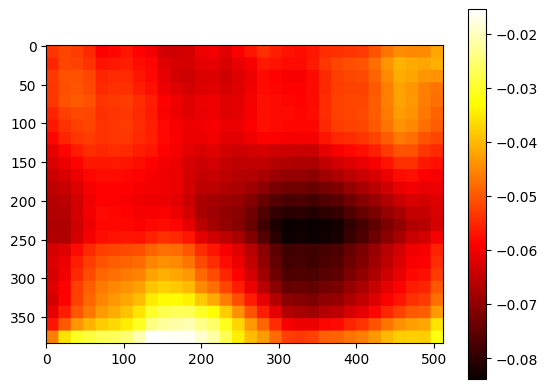

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from transformers import BlipProcessor, BlipModel
from PIL import Image
import matplotlib.pyplot as plt

# Load BLIP base model + processor
blip_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").eval()
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

@torch.no_grad()
def get_text_embedding(text):
    """Return normalized text embedding (BLIP)."""
    inputs = blip_processor(text=[text], return_tensors="pt", padding=True, truncation=True)
    text_features = blip_model.get_text_features(**inputs)  # (1, 768)
    return F.normalize(text_features, p=2, dim=-1)

@torch.no_grad()
def get_patch_embeddings(patches):
    """Return normalized embeddings for patches (BLIP)."""
    inputs = blip_processor(images=patches, return_tensors="pt", padding=True)
    image_features = blip_model.get_image_features(**inputs)  # (N, 768)
    return F.normalize(image_features, p=2, dim=-1)

def generate_heat_map(image, text, window_size=64, stride=32, batch_size=64):
    img_w, img_h = image.size
    heatmap = np.zeros((img_h, img_w), dtype=np.float32)
    count_map = np.zeros((img_h, img_w), dtype=np.float32)

    text_embedding = get_text_embedding(text)  # (1, 768)

    patch_coords, patches = [], []
    for top in range(0, img_h - window_size + 1, stride):
        for left in range(0, img_w - window_size + 1, stride):
            patch = image.crop((left, top, left + window_size, top + window_size))
            patches.append(patch)
            patch_coords.append((top, left))

            if len(patches) == batch_size:
                embed_and_update(patches, patch_coords, text_embedding, heatmap, count_map, window_size)
                patches, patch_coords = [], []

    if patches:
        embed_and_update(patches, patch_coords, text_embedding, heatmap, count_map, window_size)

    np.divide(heatmap, count_map, out=heatmap, where=count_map != 0)
    return heatmap

def embed_and_update(patches, coords, text_emb, heatmap, count_map, window_size):
    patch_embeds = get_patch_embeddings(patches)  # (N, 768)
    sims = (patch_embeds @ text_emb.T).squeeze(-1).cpu().numpy()  # cosine similarity

    for (top, left), score in zip(coords, sims):
        heatmap[top:top+window_size, left:left+window_size] += score
        count_map[top:top+window_size, left:left+window_size] += 1

def to_pil_image(np_img):
    if np_img.dtype != np.uint8:
        np_img = (np.clip(np_img, 0, 1) * 255).astype(np.uint8)
    if np_img.shape[-1] == 4:
        np_img = np_img[..., :3]
    return Image.fromarray(np_img)

# --- Main Execution ---
np_img = plt.imread("/home/lovish/PROJECTS/RealnessProject/Images/test_images/f252.png")
test_img = to_pil_image(np_img)
test_text = "The football looks oddly shaped and unrealistic."

heatmap = generate_heat_map(test_img, test_text, window_size=128, stride=16, batch_size=32)



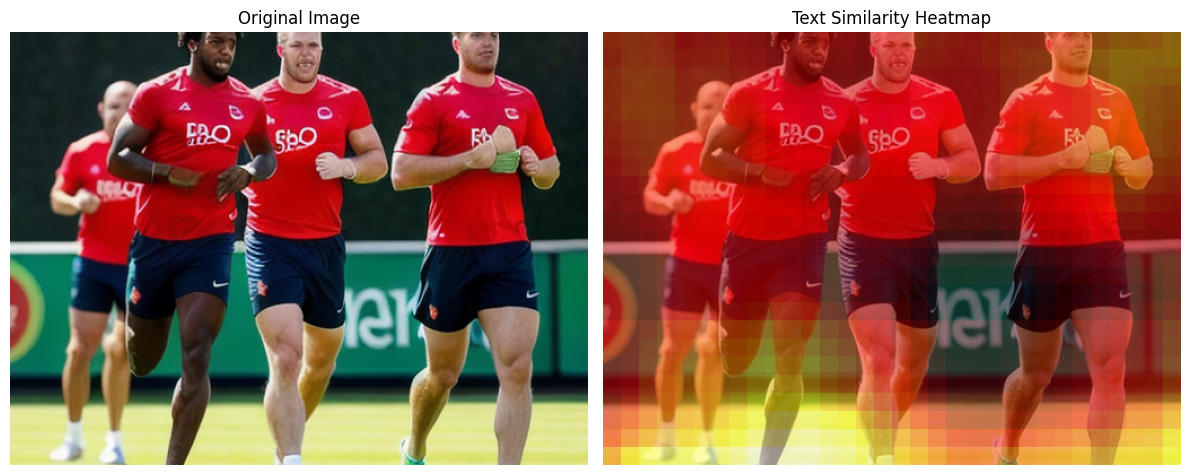

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(test_img)
plt.imshow(heatmap, cmap='hot', alpha=0.5)
plt.title("Text Similarity Heatmap")
plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
# Generate heatmap for test image 1 using Lovish's method
import os
start_times = os.times()
start_system_time = start_times.system
start_user_time = start_times.user

print("Generating heatmap1...")
heatmap1_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=4, batch_size=64)
print("Generating heatmap2...")
heatmap2_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=8, batch_size=64)
print("Generating heatmap3...")
heatmap3_img1 = generate_heat_map(test_img1, test_text1, window_size=128, stride=16, batch_size=64)

heatmap_avg1 = (heatmap1_img1 + heatmap2_img1 + heatmap3_img1) / 3

# Record system time after execution
end_times = os.times()
end_system_time = end_times.system
end_user_time = end_times.user

# Calculate system time used
system_time_used = end_system_time - start_system_time
user_time_used = end_user_time - start_user_time
print(f"System time spent: {system_time_used:.4f} seconds")
print(f"User time spent: {user_time_used:.4f} seconds")

Generating heatmap1...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x768 and 512x1)